In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from math import sin, cos, radians

from pandas._typing import FilePath
from scipy.optimize import minimize

import pickle
import os

import Constants
from Transformations import aer2eci, aer2ecef, eci2ecef, Raer2ned, pm

C:\Users\kippe\AppData\Local\Temp\ipykernel_12416\1482503440.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:

def calc_ubx_eci(row):
    # k_correction = 1 if FLAG_01_CORRECTION else 0
    return aer2eci(azim=row.azim,
                   elev=row.elev,
                   dist=row.dist,
                   lat=Constants.LLA[0],
                   lon=Constants.LLA[1],
                   # + row.TOW * Constants.OmegaEarthDot * 180 / np.pi * 0.1 * FLAG_01_CORRECTION,
                   alt=Constants.LLA[2],
                   time_sec=row.TOW)


def calc_ubx_ecef(row):
    # k_correction = 1 if FLAG_01_CORRECTION else 0
    return aer2ecef(azim=row.azim,
                    elev=row.elev,
                    dist=row.dist,
                    lat=Constants.LLA[0],
                    lon=Constants.LLA[1],
                    # + row.TOW * Constants.OmegaEarthDot * 180 / np.pi * 0.1 * FLAG_01_CORRECTION,
                    alt=Constants.LLA[2])
    # return pm.aer2ecef(row.azim, row.elev, row.dist,# *lla)
    #                    lla[0], lla[1] + row.TOW * OmegaEathDot * 180 / np.pi * 0.1, lla[2])


def calc_dist(row):
    r = Constants.ApproximateEarthRadius
    h = Constants.GPSAltitude
    if row.elev == -91:
        return np.nan
    dist = 0.5 * (
            np.sqrt(2) * np.sqrt(2 * h * h + 4 * h * r + r * r - r * r * np.cos(2 * row.elev * np.pi / 180)) -
            2 * r * np.sin(row.elev * np.pi / 180))
    return dist * 1000


def calc_dist3(row):
    aprox = calc_dist(row)

    def minimize_dist(dist):
        return abs(np.linalg.norm(aer2ecef(row.azim, row.elev, dist, *Constants.LLA)) - 5153 ** 2)

    solve = minimize(minimize_dist, aprox, tol=0.1, options={'disp': False, 'maxiter': 10})
    return solve.x


def calc_dist2(row):
    Re = Raer2ned(Constants.LLA[0], Constants.LLA[1], row.azim, row.elev)
    dist = 1 / (Re[0] ** 2 / Constants.a ** 2 + Re[1] ** 2 / Constants.a ** 2 + Re[2] ** 2 / Constants.b ** 2)
    return dist


In [4]:
def load_df(name: FilePath, H, time_correction_minus=False):
    df = pd.read_csv(
        # 'raw_2.txt',
        # 'sat_raw_calc_data1.txt',
        name,
        # 'sat2raw.log',
        sep=';', header=None,
        # names=['svId', 'gnssId', 'TOW', 'alm_x', 'alm_y', 'alm_z', 'eph_x', 'eph_y', 'eph_z',
        #        'elev', 'azim', 'doMes', 'cpMes', 'prMes'])
        names=['svId', 'gnssId', 'TOW', 'alm_x', 'alm_y', 'alm_z', 'eph_x', 'eph_y', 'eph_z',
               'elev', 'azim', 'doMes', 'cpMes', 'prMes',
               'alm_x1', 'alm_y1', 'alm_z1', 'eph_x1', 'eph_y1', 'eph_z1'])
    
    print(len(df))
    print(len(df[df.gnssId == 'GNSS.GLONASS']))
    df = df[df.gnssId == 'GNSS.GPS']
    print(len(df))
    # df = df[df.TOW > 50 * 3600]
    # print(min(df.TOW), max(df.TOW))
    # df[df.TOW < 50 * 3600].TOW += 3600 * 24 * 7
    # print(df.head())
    # df = df[df.TOW > (120 * 3600)]
    # df = df[df.TOW >= 0]
    if H:
        df = df[df.index % H == 0]
    df = df[df.TOW > 1]
    # df = df[df.TOW < 80 * 3600]
    # df.loc[df.TOW < 50 * 3600].TOW += 3600 * 24 * 7
    # df.loc[df['TOW'] > 50 * 3600, 'TOW'] -= 3600 * 24 * 7
    # df['time'] = df['TOW']# > 50 * 36003600 * 24 * 7
    # df.loc[df['time'] > 50 * 3600, 'time'] -= 3600 * 24 * 7
    if time_correction_minus:
        df.loc[df['TOW'] > 50 * 3600, 'TOW'] -= 3600 * 24 * 7

    # df.TOW += 3 * 3600

    # df = df[df.TOW > 120*3600]

    # print(min(df.TOW), max(df.TOW))
    # print(df[df.svId == 10].TOW)

    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
import os
min_time = 20

folder_path = 'images'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
COLORS = ['coral', 'yellow', 'aquamarine', 'dodgerblue', 'orange', 'teal', 'darkviolet', 'navy']

# Графики координат, выдаваемые приемником

In [25]:
ECEF = []
LLA = []
NAV_SOL = []

import re
with open('parsed3.log', 'r') as file:
# with open('parsed17.txt', 'r') as file:
    for line in file.readlines():
        if not line:
            continue
        if 'DATA:' in line:
            NAV_SOL.append(eval(line.replace('DATA:', '')))
            pass  
        elif 'NAV_POSECEF' in line:
            # pattern = r"'iTOW': (\d+)(?:, 'ecefX': (\d+))?(?:, 'ecefY': (\d+))?(?:, 'ecefZ': (\d+))?,"
            pattern = r"NAV_POSECEF: {'receiving_time': datetime\.datetime\((\d+), (\d+), (\d+), (\d+), (\d+), (\d+), (\d+), (.+)\), 'iTOW': (\d+), 'ecefX': (\d+), 'ecefY': (\d+), 'ecefZ': (\d+), 'pAcc': (\d+)}"
            matches = re.search(pattern, line)
            if not matches:
                continue
            # print(f'\"{line}\"')
            # print(matches)
            if any(matches.group(i) for i in range(9, 14)):
                ECEF.append([int(matches.group(i)) if matches.group(i) else np.nan for i in range(9, 14)])
                ECEF[-1][0] /= 1000
        elif '<NMEA(GNRMC' in line:
            # pattern = r"lon=(\d+)(?:, lat=(\d+))?(?:, *spd=(\d+))?"
            # pattern = r"(?:lon=)([\d\.]+)(?:, lat=)([\d\.]+)(?:, spd=)([\d\.]+)"
            # matches = re.search(pattern, line)
            # print(f'\"{line}\"')
            # print(matches)
            # if any(matches.group(i) for i in range(3)):
            #     LLA.append([matches.group(i) if matches.group(i) else np.nan for i in range(3) ])
            # pass
            lon_pattern = r'lon=(-?\d+\.\d+)'
            lat_pattern = r'lat=(-?\d+\.\d+)'
            spd_pattern = r'spd=(-?\d+\.\d+)'
            time_pattern = r'time=(\d{2}:\d{2}:\d{2})'
            date_pattern = r'date=(\d{4}-\d{2}-\d{2})'

            # Поиск совпадений
            matches = [
                    re.search(time_pattern, line),
                    re.search(lon_pattern, line),
                    re.search(lat_pattern, line),
                    re.search(spd_pattern, line),
                    re.search(date_pattern, line)]
            # print(f'\"{line}\"')
            # print(matches)
            if not all(matches):
                continue
            if any(matches[i].group(1) for i in range(4)):
                data = [float(matches[i].group(1)) if matches[i].group(1) else np.nan for i in range(1, 4) ]
                times = matches[0].group(1).split(':')
                # print(times)
                time = sum([int(times[i]) * 60 **(2-i) for i in range(len(times))]) + 24*3600 * int(matches[-1].group(1).split('-')[-1])
                LLA.append([time] + data)
            
        pass
print(ECEF)
print(LLA)
print(NAV_SOL)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



X
Y
Z
Точность
2844513.14 2845730.83
777 9998


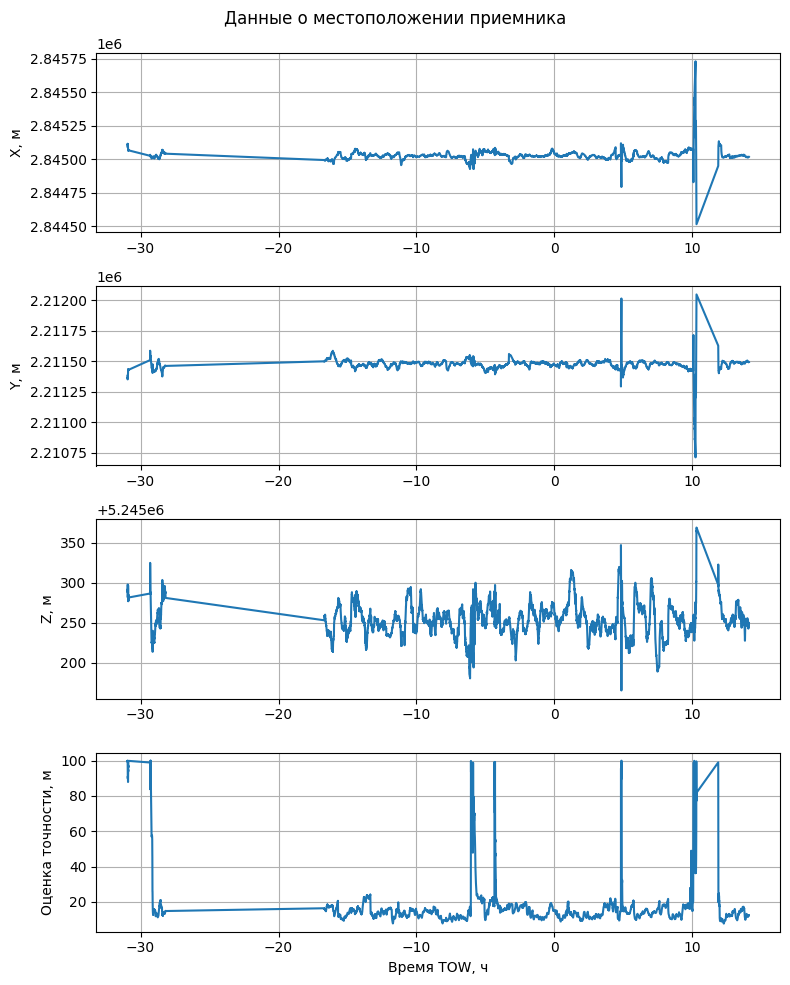

In [27]:
import pandas as pd
ecef = pd.DataFrame(ECEF, columns = ['TOW', 'X', 'Y', 'Z', 'Точность'])
# print(ecef.head(11))
# print(ecef.tail(11))

fig, axs = plt.subplots(4, figsize=(8, 10))

ecef.loc[ecef['TOW'] > 50 * 3600, 'TOW'] -= 3600 * 24 * 7

# ax.plot(htime, y3 / k - base / k, label='ubx', linestyle='-', linewidth=6, color='red',
#         alpha=0.35, zorder=-100)  # marker='o', markersize=4, linewidth=0.3)
# ax.plot(htime, y1 / k - base / k, label='alm', linestyle='-', linewidth=3.5, color='mediumaquamarine',
#         alpha=1, zorder=2)
# ax.plot(htime, y2 / k - base / k, label='eph', linestyle='--', linewidth=1.5, color='indigo',
#         alpha=1, zorder=3)
# ax.set_ylabel(ylabel)
# ax.grid()
# 
# ax.legend(loc='upper right', facecolor='lightgrey')
# 
# ymax = ax.get_ylim()[1]
# for t in np.arange(min(htime), max(htime), 12.0):
#     ax.axvline(x=t, color='y', linewidth=1)
#     if i != 2:
#         ax.text(t, ymax * 1.1, f'{round(t - min(htime)): 2} ч', color='y', ha='center')
            
            
ecef = ecef[ecef.Точность < 100 * 100]
            
for i in range(4):
    col = ecef.columns[i+1]
    print(col)
    axs[i].plot(ecef.TOW / 3600, ecef[col]/ 100)
    axs[i].set_ylabel(col + ', м')
    axs[i].grid()

axs[3].set_ylabel('Оценка точности, м')
print(min(ecef.X)/100, max(ecef.X)/100)    
print(min(ecef.Точность), max(ecef.Точность))    

axs[-1].set_xlabel('Время TOW, ч')

fig.suptitle(f"Данные о местоположении приемника")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'raw_pos_ecef.png'), dpi=500)

Широта, град
Долгота, град
Скорость, м/c


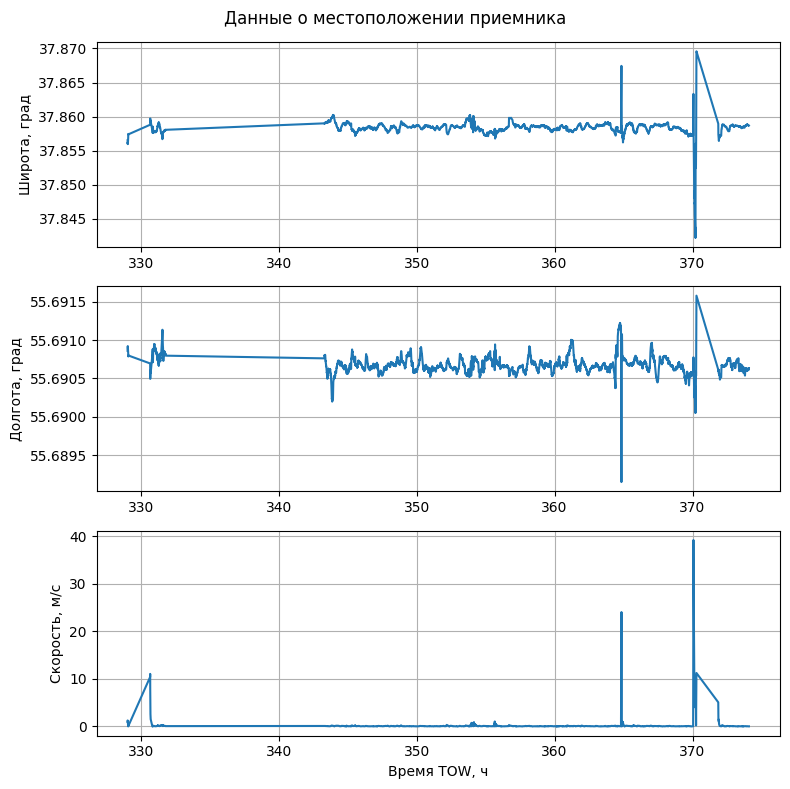

In [28]:
import pandas as pd
lla = pd.DataFrame(LLA, columns = ['time', 'Широта, град', 'Долгота, град', 'Скорость, м/c'])
# print(ecef.head(11))
# print(ecef.tail(11))

fig, axs = plt.subplots(3, figsize=(8, 8))

# ax.plot(htime, y3 / k - base / k, label='ubx', linestyle='-', linewidth=6, color='red',
#         alpha=0.35, zorder=-100)  # marker='o', markersize=4, linewidth=0.3)
# ax.plot(htime, y1 / k - base / k, label='alm', linestyle='-', linewidth=3.5, color='mediumaquamarine',
#         alpha=1, zorder=2)
# ax.plot(htime, y2 / k - base / k, label='eph', linestyle='--', linewidth=1.5, color='indigo',
#         alpha=1, zorder=3)
# ax.set_ylabel(ylabel)
# ax.grid()
# 
# ax.legend(loc='upper right', facecolor='lightgrey')
# 
# ymax = ax.get_ylim()[1]
# for t in np.arange(min(htime), max(htime), 12.0):
#     ax.axvline(x=t, color='y', linewidth=1)
#     if i != 2:
#         ax.text(t, ymax * 1.1, f'{round(t - min(htime)): 2} ч', color='y', ha='center')
            
            
# ecef = ecef[ecef.точность < 100 * 100]
            
for i in range(3):
    col = lla.columns[i+1]
    print(col)
    axs[i].plot(lla.time / 3600 - 4 * 24, lla[col] * (0.5144 if i ==3 else 1))
    axs[i].set_ylabel(col)
    axs[i].grid()


axs[-1].set_xlabel('Время TOW, ч')

fig.suptitle(f"Данные о местоположении приемника")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'raw_pos_lla.png'), dpi=500)

# График решения навигационной задачи

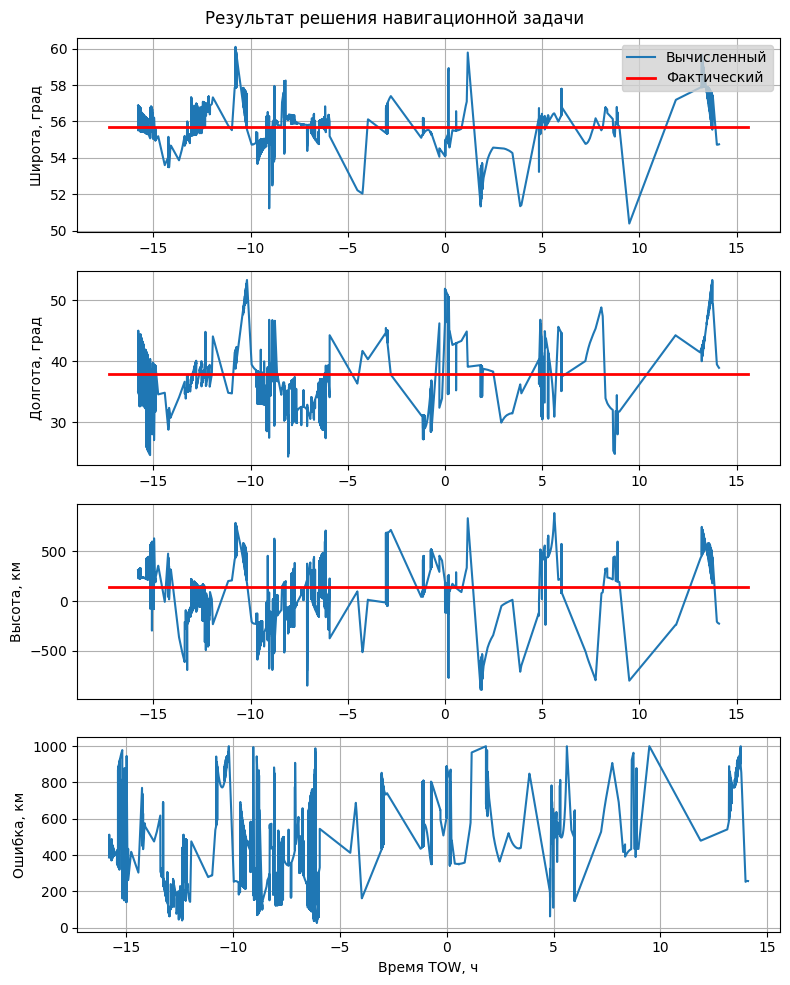

In [30]:
nav = pd.DataFrame(NAV_SOL, columns = ['Широта, град', 'Долгота, град', 'Высота, км', 'Ошибка, км', 'TOW'])

nav[nav.columns[3]] /= 1000
nav[nav.columns[2]] /= 1000

fig, axs = plt.subplots(4, figsize=(8, 10))

nav.loc[nav['TOW'] > 50 * 3600, 'TOW'] -= 3600 * 24 * 7

nav = nav[nav[nav.columns[3]] < 1e3]

            
for i in range(4):
    col = nav.columns[i]
    # print(col)
    axs[i].plot(nav.TOW / 3600, nav[col], label='Вычисленный')
    axs[i].set_ylabel(col)
    axs[i].grid()
    
for i in range(3):
    axs[i].plot(axs[i].get_xlim(), [Constants.LLA[i]]*2, label='Фактический', color='red', linewidth=2)
axs[0].legend(loc='upper right', facecolor='lightgrey')#, bbox_to_anchor=(1.05, 0.7), bbox_transform=plt.gcf().transFigure)
axs[-1].set_xlabel('Время TOW, ч')

fig.suptitle(f"Результат решения навигационной задачи")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'raw_nav.png'), dpi=500)

# Загрузка sat_raw_calc_data.txt

In [7]:
# step = 12
# df1 = load_df('sat_raw_calc_data1.txt', step, time_correction_minus=True)
# df2 = load_df('sat_raw_calc_data2.txt', step)
# df3 = load_df('sat_raw_calc_data3.txt', step)
# df = pd.concat([df1, df2, df3], ignore_index=True)
# df = load_df('sat_raw_calc_data.txt', 5, time_correction_minus=True)

# df = load_df('sat_raw_calc_data_60h.txt', 30)#, time_correction_minus=True)

df = load_df('sat_raw_calc_data2.txt', 5 * 60)  # , time_correction_minus=True)

print("DF is loaded")

9354033
3580136
5085837
DF is loaded


# Сырые данные нескольких спутников

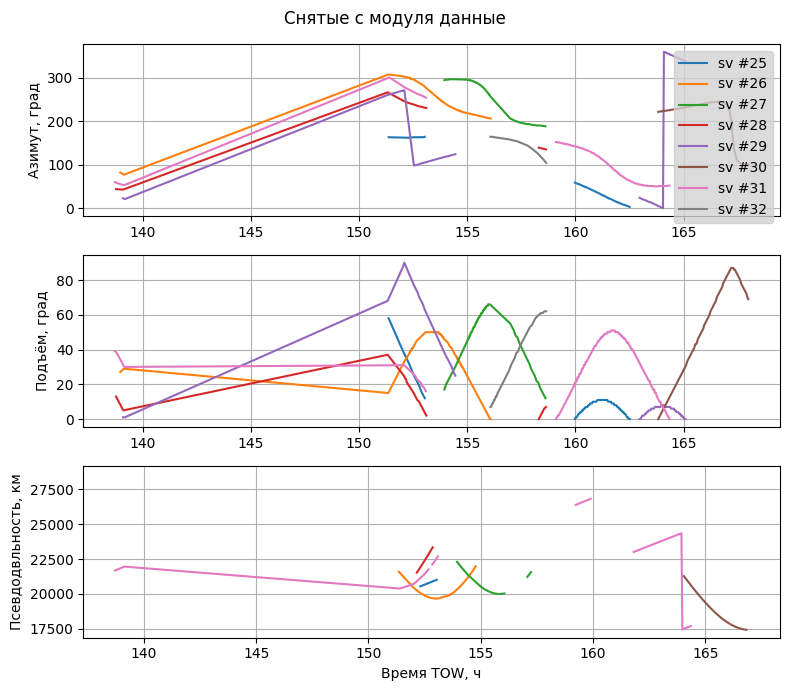

In [33]:
fig, axs = plt.subplots(3, figsize=(8, 7))

for svId in range(25, 33):#[5, 8, 9, 11, 12, 13, 14, 15]:
    # if svId in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21, 22, 23]:
    #     continue
    sat = df[df['svId'] == svId]
    sat = sat[sat.TOW > min_time * 3600]
    sat[sat.elev < 0] = np.nan
    
    axs[0].plot(sat.TOW / 3600, sat.azim, label=f'sv #{svId}')
    axs[1].plot(sat.TOW / 3600, sat.elev, label=f'sv #{svId}')
    axs[2].plot(sat.TOW / 3600, sat.prMes/1000, label=f'sv #{svId}')
for i in range(3):
    axs[i].grid()
    axs[i].set_ylabel(f'{['Азимут, град', 'Подъём, град', 'Псевдодвльность, км'][i]}')
    # axs[i].legend(loc='upper right', facecolor='lightgrey')
    if i == 0:
        axs[i].legend(loc='upper right', facecolor='lightgrey')#, bbox_to_anchor=(1.05, 0.7), bbox_transform=plt.gcf().transFigure)
    
plt.xlabel('Время TOW, ч')
fig.suptitle(f"Снятые с модуля данные")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'sats_raw.png'), dpi=500)

In [1]:

for svId in range(1, 33):
    fig, axs = plt.subplots(2, figsize=(8, 7))

    sat = df[df['svId'] == svId]
    sat.loc[sat['TOW'] > 50 * 3600, 'TOW'] -= 3600 * 24 * 7

    # sat['eph_ecef'] = sat.apply(lambda row: (row['eph_x'], row['eph_y'], row['eph_z']), axis=1)
    # sat['alm_ecef'] = sat.apply(lambda row: (row['alm_x'], row['alm_y'], row['alm_z']), axis=1)
    
    sat['prE'] = sat.apply(lambda row: 
                           np.linalg.norm(np.array([
                               row['eph_x'] - Constants.ECEF[0], 
                               row['eph_y'] - Constants.ECEF[1], 
                               row['eph_z'] - Constants.ECEF[2]
                           ]))
                           , axis=1)  
    
    sat['prA'] = sat.apply(lambda row: 
                           np.linalg.norm(np.array([
                               row['alm_x'] - Constants.ECEF[0], 
                               row['alm_y'] - Constants.ECEF[1], 
                               row['alm_z'] - Constants.ECEF[2]
                           ]))
                           , axis=1)  
    
    axs[0].plot(sat.TOW / 3600, sat.prMes/1000, label=f'prMes')
    axs[0].plot(sat.TOW / 3600, sat.prA/1000, label=f'alm dist')
    axs[0].plot(sat.TOW / 3600, sat.prE/1000, label=f'eph dist', linestyle='--')

    axs[0].set_ylabel('Pseudorange, km')
    
    axs[1].plot(sat.TOW/3600, (sat.prMes - sat.prA)/1000, label='prMes - alm dist')
    axs[1].set_ylabel('Pseudorange error, km')
    
    for i in range(2):
        axs[i].legend(loc='upper right', facecolor='lightgrey')
        axs[i].grid()
    
    plt.xlabel('Время TOW, ч')
    fig.suptitle(f"Псевдодальности и дальности до спутника #{svId}")
    plt.tight_layout()
    plt.savefig(os.path.join('prs2', f'pr{svId}.png'), dpi=500)
    
    del sat
    


NameError: name 'plt' is not defined

C:\Users\kippe\AppData\Local\Temp\ipykernel_12416\3561322379.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat['prE'] = sat.apply(lambda row:
C:\Users\kippe\AppData\Local\Temp\ipykernel_12416\3561322379.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat['prA'] = sat.apply(lambda row:
C:\Users\kippe\AppData\Local\Temp\ipykernel_12416\3561322379.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

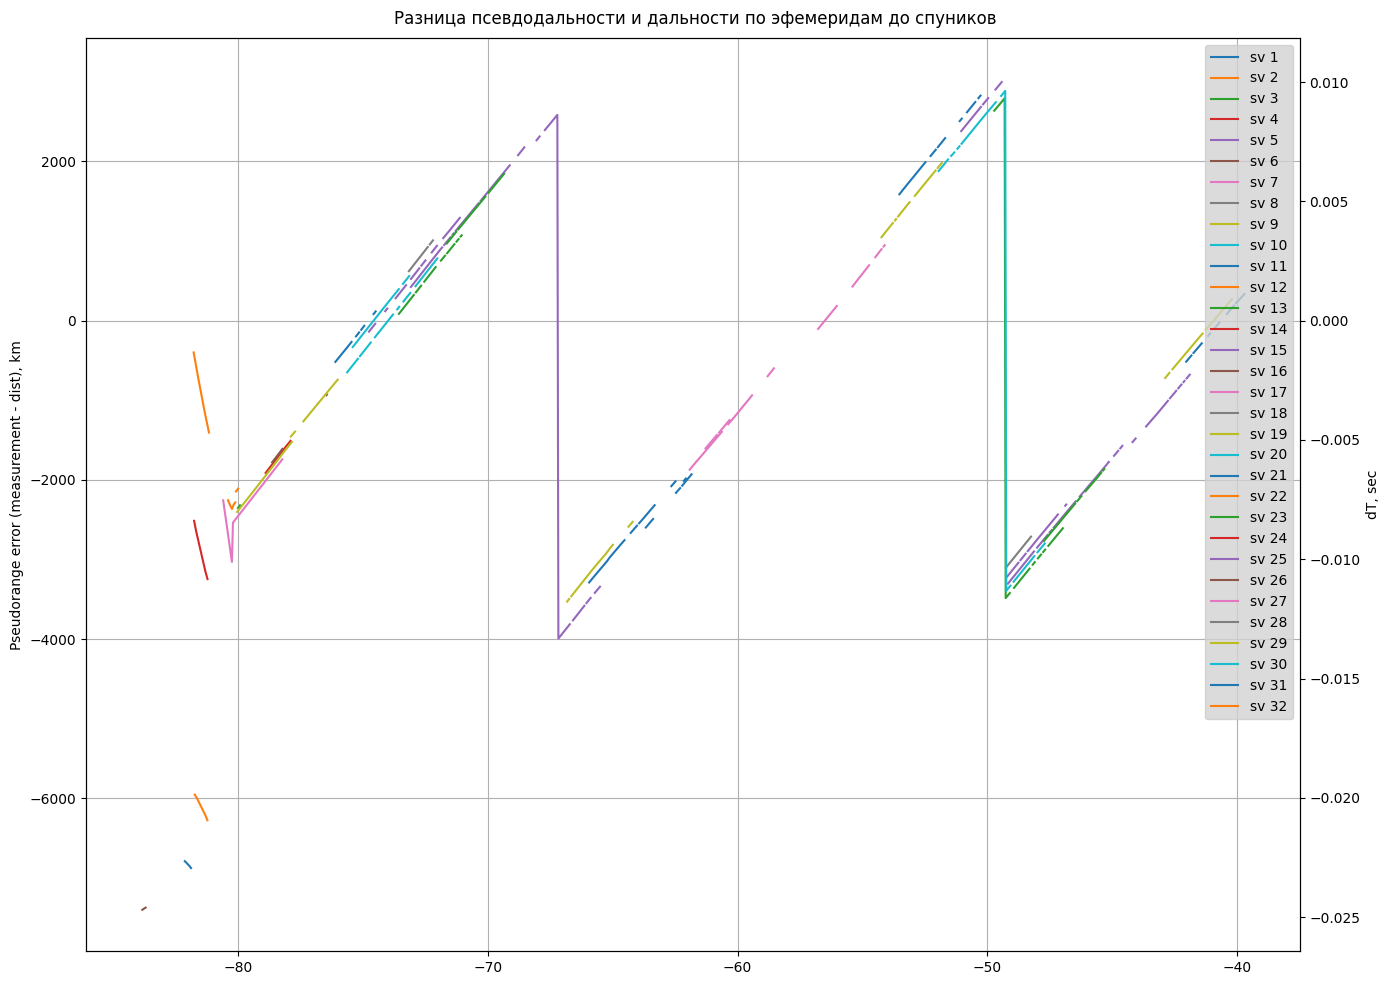

In [24]:
fig, axs = plt.subplots(1, figsize=(14, 10))

for svId in range(1, 33):

    sat = df[df['svId'] == svId]
    sat.loc[sat['TOW'] > 50 * 3600, 'TOW'] -= 3600 * 24 * 7

    # sat['eph_ecef'] = sat.apply(lambda row: (row['eph_x'], row['eph_y'], row['eph_z']), axis=1)
    # sat['alm_ecef'] = sat.apply(lambda row: (row['alm_x'], row['alm_y'], row['alm_z']), axis=1)
    
    sat['prE'] = sat.apply(lambda row: 
                           np.linalg.norm(np.array([
                               row['eph_x'] - Constants.ECEF[0], 
                               row['eph_y'] - Constants.ECEF[1], 
                               row['eph_z'] - Constants.ECEF[2]
                           ]))
                           , axis=1)  
    
    sat['prA'] = sat.apply(lambda row: 
                           np.linalg.norm(np.array([
                               row['alm_x'] - Constants.ECEF[0], 
                               row['alm_y'] - Constants.ECEF[1], 
                               row['alm_z'] - Constants.ECEF[2]
                           ]))
                           , axis=1)  
    
    # axs[0].plot(sat.TOW / 3600, sat.prMes/1000, label=f'prMes')
    # axs[0].plot(sat.TOW / 3600, sat.prA/1000, label=f'alm dist')
    # axs[0].plot(sat.TOW / 3600, sat.prE/1000, label=f'eph dist', linestyle='--')

    # axs[0].set_ylabel('Pseudorange, km')
    
    # axs[1].plot(sat.TOW/3600, (sat.prMes - sat.prA)/1000, label='prMes - alm dist')
    axs.plot(sat.TOW/3600, (sat.prMes - sat.prE)/1000, label=f'sv {svId}')
    
    del sat
    
    # for i in range(2):
axs.legend(loc='upper right', facecolor='lightgrey')
axs.grid()
axs.set_ylabel('Pseudorange error (measurement - dist), km')


axs2 = axs.twinx()
lim1 = axs.get_ylim()
lim2 = np.array(lim1) / Constants.c * 1000
axs2.set_ylim(lim2)
axs2.set_ylabel('dT, sec')

plt.xlabel('Время TOW, ч')
fig.suptitle(f"Разница псевдодальности и дальности по эфемеридам до спуников")
plt.tight_layout()
plt.savefig(f'pr_error_all_eph.png', dpi=500)

    


In [35]:
svId = 25

sat = df[df.svId == svId]
# sat = sat[sat.TOW > 10]
sat.reset_index(drop=True, inplace=True)


sat['eph_ecef'] = sat.apply(lambda row: (row['eph_x'], row['eph_y'], row['eph_z']), axis=1)
# sat = sat.drop(columns=['alm_x', 'alm_y', 'alm_z'])
# sat['alm_ecef'] = sat.apply(lambda row: eci2ecef(row['TOW'], *row['alm']), axis=1)
sat['alm_lla'] = sat.apply(lambda row: pm.ecef2geodetic(*row['alm_ecef']), axis=1)
# print(f'sv{svId}: alm calculated')

sat['eph_ecef'] = sat.apply(lambda row: (row['eph_x'], row['eph_y'], row['eph_z']), axis=1)
# sat = sat.drop(columns=['eph_x', 'eph_y', 'eph_z'])
# sat['eph_ecef'] = sat.apply(lambda row: eci2ecef(row['TOW'], *row['eph']), axis=1)
sat['eph_lla'] = sat.apply(lambda row: pm.ecef2geodetic(*row['eph_ecef']), axis=1)
# print(f'sv{svId}: eph calculated')

sat['dist'] = sat.apply(calc_dist, axis=1)
# sat['ubx_ecef'] = sat.apply(calc_ubx_ecef, axis=1)
# sat['ubx'] = sat.apply(calc_ubx_eci, axis=1)
# sat['ubx'] = sat.apply(lambda row: ecef2eci(row['TOW'], *row['ubx_ecef']), axis=1)
# print(f'sv{svId}: ubx calculated')
# sat['ubx'] = sat.apply(calc_ubx_eci, axis=1)
sat['ubx_ecef'] = sat.apply(calc_ubx_ecef, axis=1)  # sat.apply(lambda row: eci2ecef(row['TOW'], *row['ubx']), axis=1)
sat['ubx_lla'] = sat.apply(lambda row: pm.ecef2geodetic(*row['ubx_ecef']), axis=1)




sat = sat[sat.TOW > min_time * 3600]
htime = sat.TOW / 3600

print(sat)

C:\Users\kippe\AppData\Local\Temp\ipykernel_15496\372215706.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat['alm_ecef'] = sat.apply(lambda row: (row['alm_x'], row['alm_y'], row['alm_z']), axis=1)
C:\Users\kippe\AppData\Local\Temp\ipykernel_15496\372215706.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat['alm_lla'] = sat.apply(lambda row: pm.ecef2geodetic(*row['alm_ecef']), axis=1)
C:\Users\kippe\AppData\Local\Temp\ipykernel_15496\372215706.py:14: SettingWithCopyWarning: 
A value is trying to

     svId    gnssId       TOW         alm_x         alm_y         alm_z  \
1      25  GNSS.GPS  492718.0           NaN           NaN           NaN   
2      25  GNSS.GPS  492868.0           NaN           NaN           NaN   
3      25  GNSS.GPS  493018.0           NaN           NaN           NaN   
4      25  GNSS.GPS  493168.0           NaN           NaN           NaN   
5      25  GNSS.GPS  494180.0           NaN           NaN           NaN   
..    ...       ...       ...           ...           ...           ...   
311    25  GNSS.GPS  604106.0  2.435609e+06 -1.542024e+07 -2.181793e+07   
312    25  GNSS.GPS  604256.0  2.837999e+06 -1.538327e+07 -2.179113e+07   
313    25  GNSS.GPS  604406.0  3.240180e+06 -1.534980e+07 -2.175420e+07   
314    25  GNSS.GPS  604556.0  3.641937e+06 -1.531982e+07 -2.170716e+07   
315    25  GNSS.GPS  604706.0  4.043054e+06 -1.529333e+07 -2.165003e+07   

     eph_x  eph_y  eph_z  elev  ...  eph_x1  eph_y1  eph_z1  \
1      NaN    NaN    NaN   NaN  ... 

C:\Users\kippe\AppData\Local\Temp\ipykernel_15496\372215706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat['ubx_lla'] = sat.apply(lambda row: pm.ecef2geodetic(*row['ubx_ecef']), axis=1)


# График альманаха с зонами

svId                     25
gnssId             GNSS.GPS
TOW                302705.0
alm_x                   NaN
alm_y                   NaN
alm_z                   NaN
eph_x                   NaN
eph_y                   NaN
eph_z                   NaN
elev                    NaN
azim                    NaN
doMes                   NaN
cpMes                   NaN
prMes                   NaN
alm_x1                  NaN
alm_y1                  NaN
alm_z1                  NaN
eph_x1                  NaN
eph_y1                  NaN
eph_z1                  NaN
alm_ecef    (nan, nan, nan)
alm_lla     (nan, nan, nan)
eph_ecef    (nan, nan, nan)
eph_lla     (nan, nan, nan)
dist                    NaN
ubx_ecef    [nan, nan, nan]
ubx_lla     (nan, nan, nan)
Name: 0, dtype: object
0


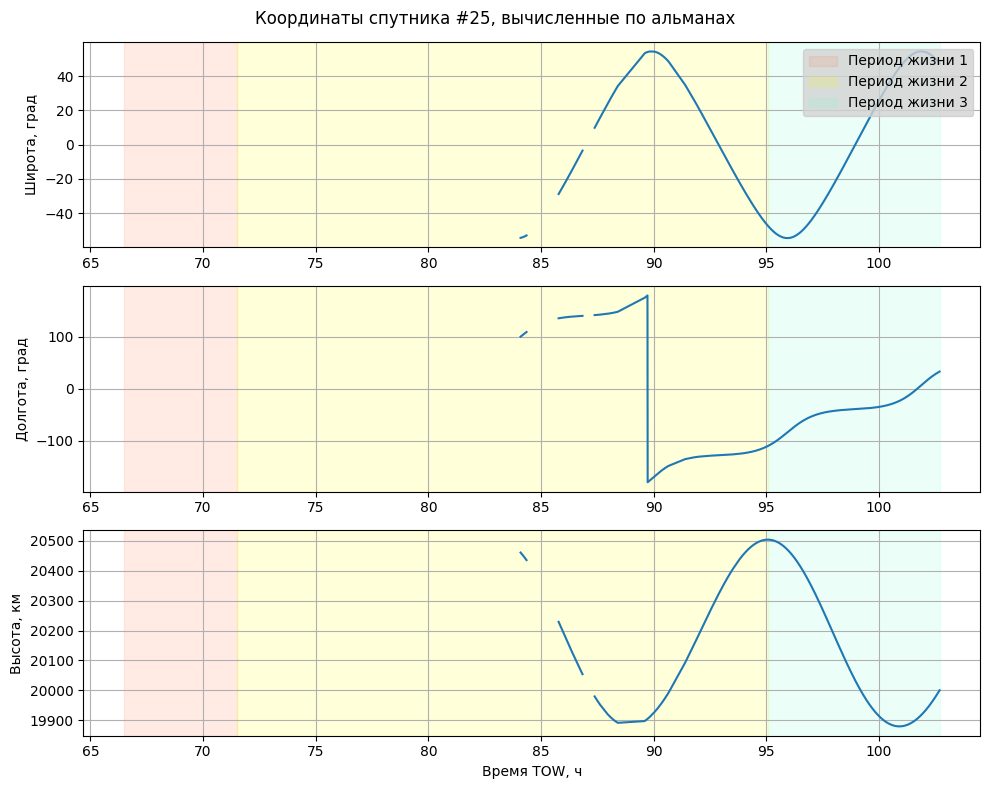

In [11]:
# COLORS = ['coral', 'yellow', 'aquamarine', 'dodgerblue', 'orange', 'teal', 'darkviolet', 'navy']
fig, axs = plt.subplots(3, figsize=(10, 8))
tows = np.array([239389, 257482, 342234, sat.TOW[sat.index[-1]]]) / 3600

TOW_CHOSEN = 75 * 3600

choosed = sat.loc[sat.TOW > TOW_CHOSEN]
# index = htime.loc[htime > TOW_CHOSEN/3600].iloc[0]
row = choosed.iloc[0]
index = choosed.index[0]
print(row)
print(index)



for i in range(3):
    axs[i].plot(sat.TOW / 3600, sat.alm_lla.apply(lambda x: x[i] / (1000 if i ==2 else 1)))
    axs[i].grid()
    axs[i].set_ylabel(f'{['Широта, град', 'Долгота, град', 'Высота, км'][i]}')
    for j in range(len(tows) - 1):
        # print(tows[j], tows[j+1])
        axs[i].axvspan(tows[j], tows[j + 1], alpha=0.15, color=COLORS[j],
                       label=f'Период жизни {j+1}')
    
    x, y = sat.TOW[index]/3600, sat.alm_lla.apply(lambda x: x[i] / (1000 if i ==2 else 1))[index]
    # ax.scatter(x, y, marker='*', color='dodgerblue', zorder=1000)
    axs[i].scatter(x, y, marker='*', color='yellow', edgecolor='dodgerblue', s=100, zorder=1000)

    axs[i].annotate(f'({y:.1f})', xy=(x, y), xytext=(-20, 15), textcoords='offset points', color='dodgerblue', zorder=1000, 
                             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  # Фон и обводка
    if i == 0:
        axs[i].legend(loc='upper right', facecolor='lightgrey')
    
plt.xlabel('Время TOW, ч')
fig.suptitle(f"Координаты спутника #{svId}, вычисленные по альманах")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'sat_ALM{svId:02}.png'), dpi=500)


# График эфемерид 

svId                     25
gnssId             GNSS.GPS
TOW                302705.0
alm_x                   NaN
alm_y                   NaN
alm_z                   NaN
eph_x                   NaN
eph_y                   NaN
eph_z                   NaN
elev                    NaN
azim                    NaN
doMes                   NaN
cpMes                   NaN
prMes                   NaN
alm_x1                  NaN
alm_y1                  NaN
alm_z1                  NaN
eph_x1                  NaN
eph_y1                  NaN
eph_z1                  NaN
alm_ecef    (nan, nan, nan)
alm_lla     (nan, nan, nan)
eph_ecef    (nan, nan, nan)
eph_lla     (nan, nan, nan)
dist                    NaN
ubx_ecef    [nan, nan, nan]
ubx_lla     (nan, nan, nan)
Name: 0, dtype: object
0


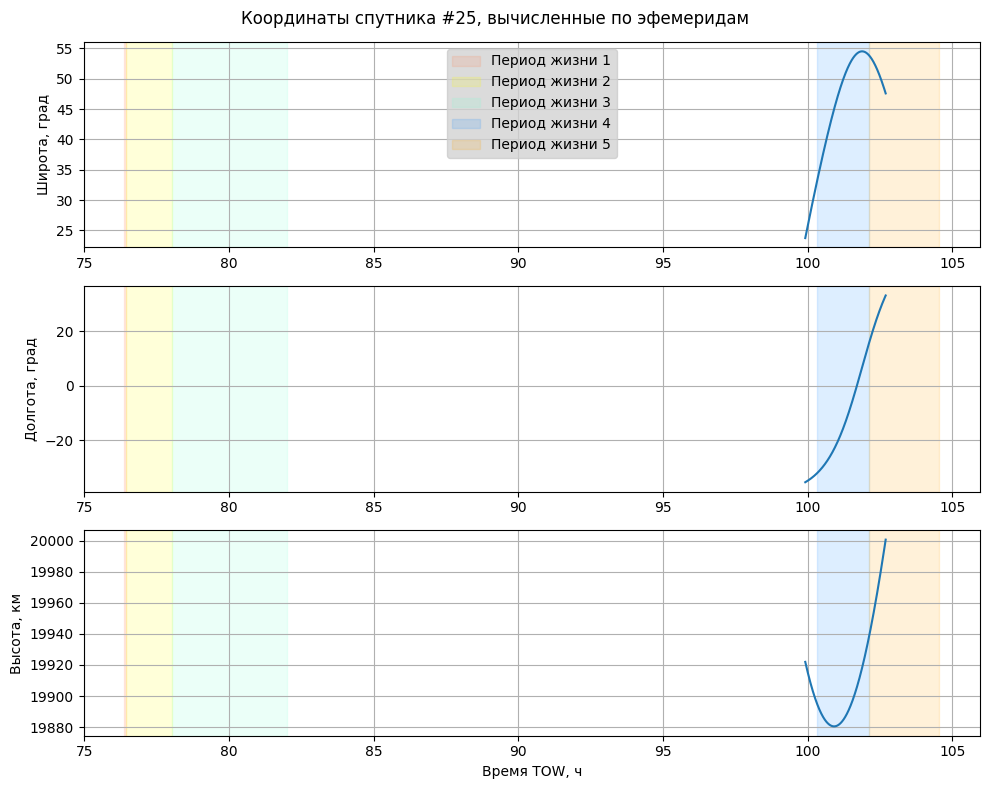

In [12]:
fig, axs = plt.subplots(3, figsize=(10, 8))


if svId == 30:
    ## 30
    tows = [
        np.array([250932, 252101, 266417]) / 3600, 
        np.array([336964, 338418, 352802]) / 3600,
        # np.array([72, 73.5, 76]) / 3600
    ]
elif svId == 25:
    ## 25
    tows = [
        np.array([274967, 275147, 280913, 295196]) / 3600, 
        np.array([361188, 367620, 376381]) / 3600,
        # np.array([72, 73.5, 76]) / 3600
    ]


TOW_CHOSEN = 80 * 3600
choosed = sat.loc[sat.TOW > TOW_CHOSEN]
# index = htime.loc[htime > TOW_CHOSEN/3600].iloc[0]
row = choosed.iloc[0]
index = choosed.index[0]
print(row)
print(index)
    
for i in range(3):
    axs[i].plot(sat.TOW / 3600, sat.eph_lla.apply(lambda x: x[i] / (1000 if i ==2 else 1)))
    axs[i].grid()
    axs[i].set_ylabel(f'{['Широта, град', 'Долгота, град', 'Высота, км'][i]}')
    # for tow in tows:
    #     for j in range(len(tows) - 1):
    #         # print(tows[j], tows[j+1])
    
    x, y = sat.TOW[index]/3600, sat.eph_lla.apply(lambda x: x[i] / (1000 if i ==2 else 1))[index]
    # ax.scatter(x, y, marker='*', color='dodgerblue', zorder=1000)
    axs[i].scatter(x, y, marker='*', color='yellow', edgecolor='dodgerblue', s=100, zorder=1000)

    axs[i].annotate(f'({y:.1f})', xy=(x, y), xytext=(-20, 15), textcoords='offset points', color='dodgerblue', zorder=1000, 
                             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  # Фон и обводка

    count = 0
    for row in tows:
        for j in range(len(row) - 1):
            axs[i].axvspan(row[j], row[j+1], alpha=0.15, label=f'Период жизни {count+1}', color=COLORS[count])
            count += 1
    if i == 0:
        axs[i].legend(loc='upper center', facecolor='lightgrey')
    # lims = axs[i].get_xlim()
    # axs[i].set_xlim(lims[0], lims[1]+8)
    
plt.xlabel('Время TOW, ч')
fig.suptitle(f"Координаты спутника #{svId}, вычисленные по эфемеридам")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'sat_EPH{svId:02}.png'), dpi=500)

# График ГГСК + ГСК для eph, alm и ubx 

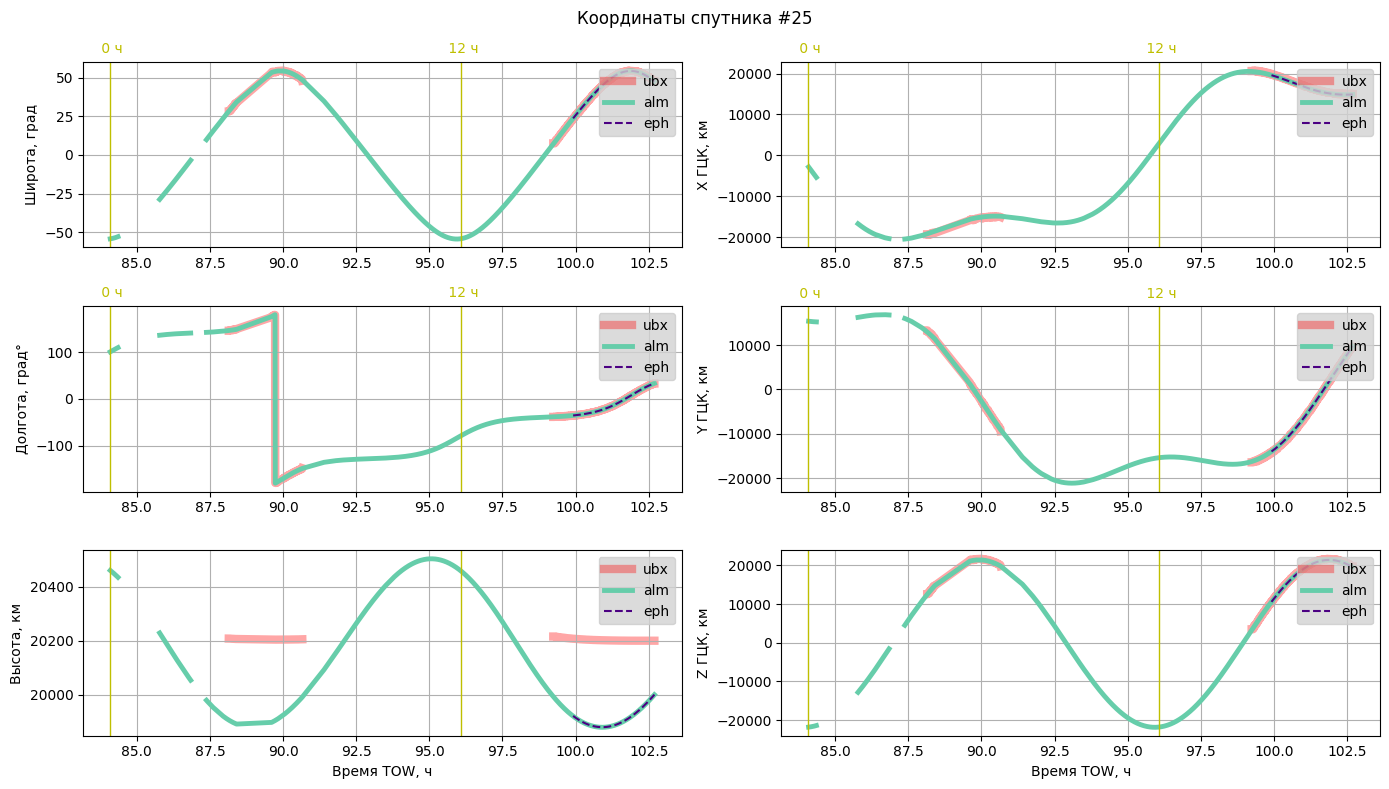

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(14, 8))



def plot_axs(i, j, y1, y2, y3, ylabel, k=1000, base=0):
    if axs.shape == (3, 1):
        ax = axs[i]
    else:
        ax = axs[i, j]
    ax.plot(htime, y3 / k - base / k, label='ubx', linestyle='-', linewidth=6, color='red',
            alpha=0.35, zorder=-100)  # marker='o', markersize=4, linewidth=0.3)
    ax.plot(htime, y1 / k - base / k, label='alm', linestyle='-', linewidth=3.5, color='mediumaquamarine',
            alpha=1, zorder=2)
    ax.plot(htime, y2 / k - base / k, label='eph', linestyle='--', linewidth=1.5, color='indigo',
            alpha=1, zorder=3)
    ax.set_ylabel(ylabel)
    ax.grid()
    
    
    ax.legend(loc='upper right', facecolor='lightgrey')

    ymax = ax.get_ylim()[1]
    for t in np.arange(min(htime), max(htime), 12.0):
        ax.axvline(x=t, color='y', linewidth=1)
        if i != 2:
            ax.text(t, ymax * 1.1, f'{round(t - min(htime)): 2} ч', color='y', ha='center')
            
for i in range(3):
    plot_axs(i, 0, sat.alm_lla.apply(lambda x: x[i]), sat.eph_lla.apply(lambda x: x[i]),
             sat.ubx_lla.apply(lambda x: x[i]), ['Широта, град', 'Долгота, град°', 'Высота, км'][i],
             k=1000 if i ==2 else 1)  # + ' ecef, K=1.1 км')#, sat.ubx_ecef.apply(lambda x: x[i]))  # , sat.alm.apply(lambda x: x[i]))
    plot_axs(i, 1, sat.alm_ecef.apply(lambda x: x[i]), sat.eph_ecef.apply(lambda x: x[i]),
             sat.ubx_ecef.apply(lambda x: x[i]), 'XYZ'[i] + ' ГЦК, км',
             k=1000)  # , sat.alm_ecef.apply(lambda x: x[i]))

axs[-1, 0].set_xlabel('Время TOW, ч')
axs[-1, 1].set_xlabel('Время TOW, ч')

fig.suptitle(f"Координаты спутника #{svId}")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'sat_lla_ecef{svId:02}.png'), dpi=500)

# Графики ошибок относительно UBX

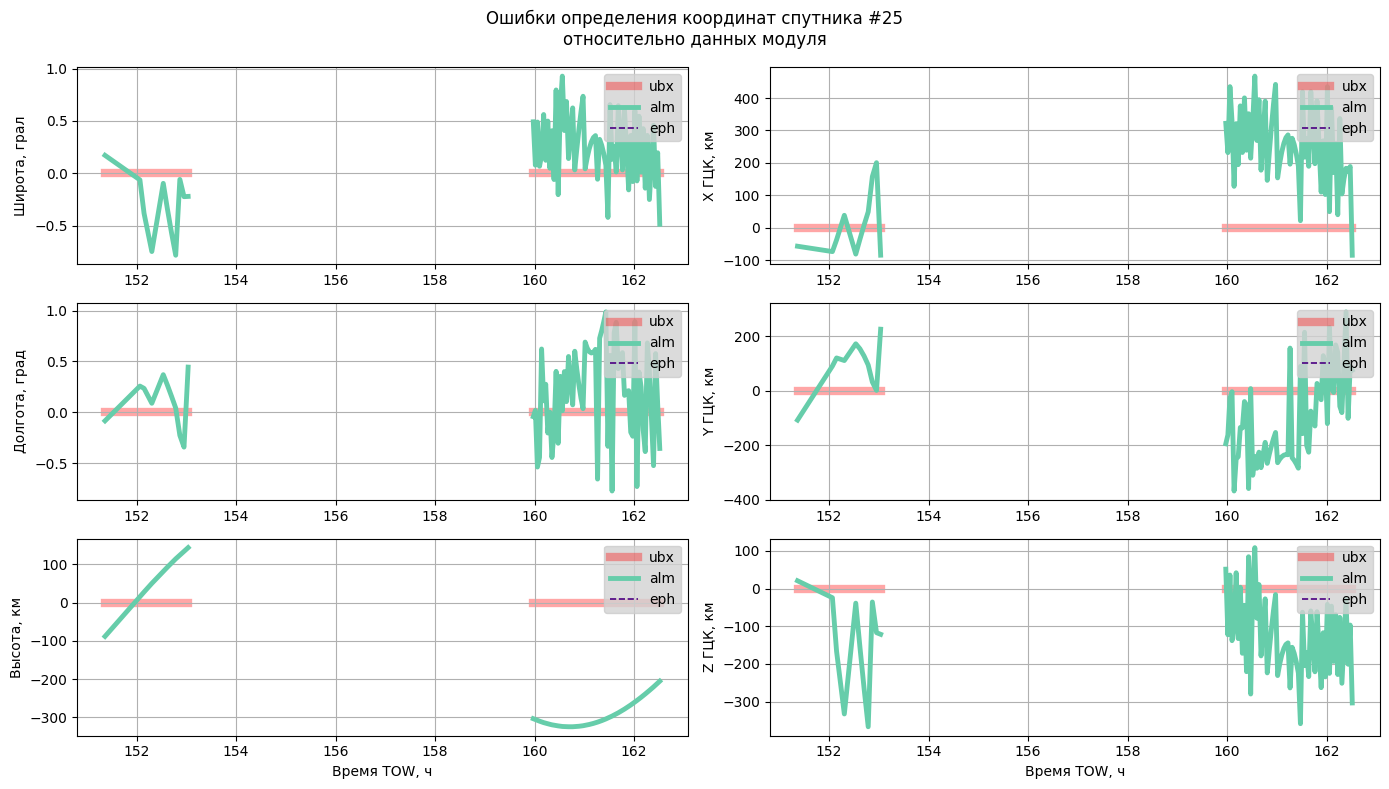

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(14, 8))

def plot_axs(i, j, y1, y2, y3, ylabel, k=1000, base=0):
    if axs.shape == (3, 1):
        ax = axs[i]
    else:
        ax = axs[i, j]
    Y1 = y1 / k - base / k
    Y2 = y2 / k - base / k
    Y3 = y3 / k - base / k
    if i == 1 and j == 0:
        Y1 = (Y1+180) % 360 - 180
        Y2 = (Y2+180) % 360 - 180
        Y3 = (Y3+180) % 360 - 180
    
    ax.plot(htime, Y3, label='ubx', linestyle='-', linewidth=6, color='red',
            alpha=0.35, zorder=-100)  # marker='o', markersize=4, linewidth=0.3)
    ax.plot(htime, Y1, label='alm', linestyle='-', linewidth=3.5, color='mediumaquamarine',
            alpha=1, zorder=2)
    ax.plot(htime, Y2, label='eph', linestyle='--', linewidth=1.2, color='indigo',
            alpha=1, zorder=3)
    ax.set_ylabel(ylabel)
    ax.grid()

    ax.legend(loc='upper right', facecolor='lightgrey')

    # ymax = ax.get_ylim()[1]
    # for t in np.arange(min(htime), max(htime), 12.0):
    #     ax.axvline(x=t, color='y', linewidth=1)
    #     if i != 2:
    #         ax.text(t, ymax * 1.1, f'{round(t - min(htime)): 2} ч', color='y', ha='center')

for i in range(3):
    plot_axs(i, 0, sat.alm_lla.apply(lambda x: x[i] / (1e3 if i == 2 else 1)), sat.eph_lla.apply(lambda x: x[i] / (1e3 if i == 2 else 1)),
             sat.ubx_lla.apply(lambda x: x[i] / (1e3 if i == 2 else 1)), ['Широта, грал', 'Долгота, град', 'Высота, км'][i],
             k=1, base=sat.ubx_lla.apply(lambda x: x[i]) / (1e3 if i == 2 else 1))  # , sat.alm.apply(lambda x: x[i]))
    plot_axs(i, 1, sat.alm_ecef.apply(lambda x: x[i]), sat.eph_ecef.apply(lambda x: x[i]),
             sat.ubx_ecef.apply(lambda x: x[i]), 'XYZ'[i] + ' ГЦК, км',
             k=1000, base=sat.ubx_ecef.apply(lambda x: x[i]))

axs[-1, 0].set_xlabel('Время TOW, ч')
axs[-1, 1].set_xlabel('Время TOW, ч')

fig.suptitle(f"Ошибки определения координат спутника #{svId}\nотносительно данных модуля")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'sat_lla_ecef_error{svId:02}.png'), dpi=500)

# График ошибок альманаха относителньо эфимерид


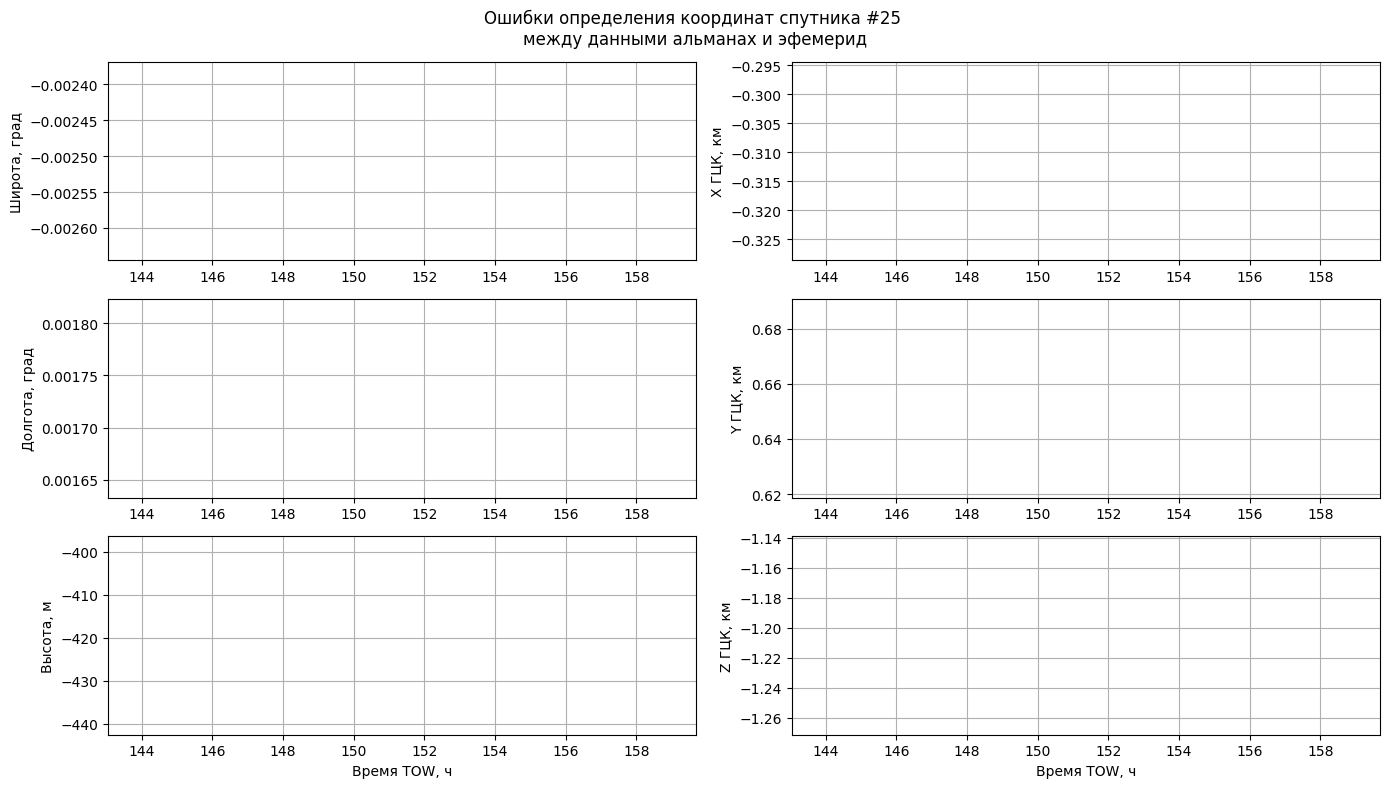

In [37]:
fig, axs = plt.subplots(3, 2, figsize=(14, 8))



def plot_axs(i, j, y1, y2, ylabel,  k=1000, base=0):
    if axs.shape == (3, 1):
        ax = axs[i]
    else:
        ax = axs[i, j]
    ax.plot(htime, (y1-y2) / k - base / k, label='alm', linestyle='-', linewidth=3.5, color='mediumaquamarine',
            alpha=1, zorder=2)
    # ax.plot(htime, y2 / k - base / k, label='eph', linestyle='--', linewidth=1.5, color='indigo',
    #         alpha=1, zorder=3)
    ax.set_ylabel(ylabel)
    ax.grid()

    # ax.legend(loc='upper right', facecolor='lightgrey')

    # ymax = ax.get_ylim()[1]
    # for t in np.arange(min(htime), max(htime), 12.0):
    #     ax.axvline(x=t, color='y', linewidth=1)
    #     if i != 2:
    #         ax.text(t, ymax * 1.1, f'{round(t - min(htime)): 2} ч', color='y', ha='center')
            
for i in range(3):
    plot_axs(i, 0, sat.alm_lla.apply(lambda x: x[i]), sat.eph_lla.apply(lambda x: x[i]), ['Широта, град', 'Долгота, град', 'Высота, м'][i],
             k=1)  # + ' ecef, K=1.1 км')#, sat.ubx_ecef.apply(lambda x: x[i]))  # , sat.alm.apply(lambda x: x[i]))
    plot_axs(i, 1, sat.alm_ecef.apply(lambda x: x[i]), sat.eph_ecef.apply(lambda x: x[i]), 'XYZ'[i] + ' ГЦК, км',
             k=1000)  # , sat.alm_ecef.apply(lambda x: x[i]))

axs[-1, 0].set_xlabel('Время TOW, ч')
axs[-1, 1].set_xlabel('Время TOW, ч')

fig.suptitle(f"Ошибки определения координат спутника #{svId} \nмежду данными альманах и эфемерид")
plt.tight_layout()
plt.savefig(os.path.join(folder_path, f'sat_alm_eph_error{svId:02}.png'), dpi=500)